# Linear Regression

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

### Loading the dataset

In [2]:
data = pd.read_csv('../dataset/spotify_features.csv', sep=',')
data.head()

,Date,Open Price,High Price,Low Price,Close Price,Volume
0,2002-05-23,16.19,17.40,16.04,16.75,7485000.0
1,2002-05-24,17.00,17.15,16.76,16.94,793200.0
2,2002-05-28,16.99,17.25,16.20,16.20,472100.0
3,2002-05-29,16.30,16.30,15.20,15.45,482700.0
4,2002-05-30,15.51,15.51,15.00,15.00,725300.0


### Data Preprocessing

In [4]:
X = data.drop(columns=['track_popularity'])
y = data['track_popularity']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25)

print(f'Training set: {X_train.shape}, {y_train.shape}')
print(f'Validation set: {X_val.shape}, {y_val.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Training set: (3609, 4), (3609,)
Validation set: (903, 4), (903,)
Test set: (1128, 4), (1128,)


### Standardization

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### Model Training

In [6]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

### Model Evaluation

In [7]:
train_score = model.score(X_train_scaled, y_train)
val_score = model.score(X_val_scaled, y_val)
test_score = model.score(X_test_scaled, y_test)

print(f"Train R^2: {train_score:.2f}")
print(f"Validation R^2: {val_score:.2f}")
print(f"Test R^2: {test_score:.2f}")

mae = mean_absolute_error(y_test, model.predict(X_test))
print(f'MAE: {mae:.2f}')
mse = mean_squared_error(y_test, model.predict(X_test))
print(f'MSE: {mse:.2f}')

Train R^2: 0.20
Validation R^2: 0.23
Test R^2: 0.23
MAE: 1012342816.28
MSE: 1923941985917701120.00


C:\Users\ilian\Documents\School\VirtualEnviromentsPython\artificialIntelligenceProject_2024_2025\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
C:\Users\ilian\Documents\School\VirtualEnviromentsPython\artificialIntelligenceProject_2024_2025\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


### Cross-validation #1

In [7]:
scores = cross_validate(model, X, y, cv=6, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.015476,0.000979,-0.045088,0.053232
1,0.011217,0.001507,-0.014748,0.056243
2,0.034697,0.002386,-0.041440,0.064373
3,0.009552,0.002871,-0.004395,0.038981
4,0.011106,0.001005,-0.030885,0.057592
5,0.010021,0.001987,-0.200804,0.043608


### Hyperparamter Tuning

#### Ridge & Lasso

In [8]:
# Pipeline with standard scaling and ridge or lasso regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())  # Start with Ridge, can change to Lasso for comparison
])

# Hyperparameters for Ridge and Lasso
ridge_params = {
    'regressor': [Ridge()],
    'regressor__alpha': [0.1, 1.0, 10, 50, 100]
}

lasso_params = {
    'regressor': [Lasso()],
    'regressor__alpha': [0.01, 0.1, 1.0, 10, 50]
}

# Combine both parameter sets for GridSearch
param_grid = [ridge_params, lasso_params]

# GridSearchCV setup with 5-fold cross-validation
gridsearch = GridSearchCV(pipeline, param_grid, cv=8, scoring='r2', n_jobs=-1) 
gridsearch.fit(X_train, y_train)

# Best estimator and its scores
print(f"Best parameters: {gridsearch.best_params_}")
best_model = gridsearch.best_estimator_

# Evaluate best model on training, validation, and test sets
train_score = best_model.score(X_train, y_train)
val_score = best_model.score(X_val, y_val)
test_score = best_model.score(X_test, y_test)

print(f"Best Model Train R^2: {train_score:.2f}")
print(f"Best Model Validation R^2: {val_score:.2f}")
print(f"Best Model Test R^2: {test_score:.2f}")

# this may suggest that the relationship between features and target is non-linear

Best parameters: {'regressor': Ridge(), 'regressor__alpha': 0.1}
Best Model Train R^2: 0.20
Best Model Validation R^2: 0.22
Best Model Test R^2: 0.23


### Cross-validation #2

In [9]:
scores = cross_validate(model, X, y, cv=6, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.020534,0.002161,-0.045088,0.053232
1,0.011577,0.002117,-0.014748,0.056243
2,0.006011,0.001158,-0.041440,0.064373
3,0.005891,0.001152,-0.004395,0.038981
4,0.005567,0.001133,-0.030885,0.057592
5,0.006722,0.001998,-0.200804,0.043608


### Visualizations

#### Feature Importance

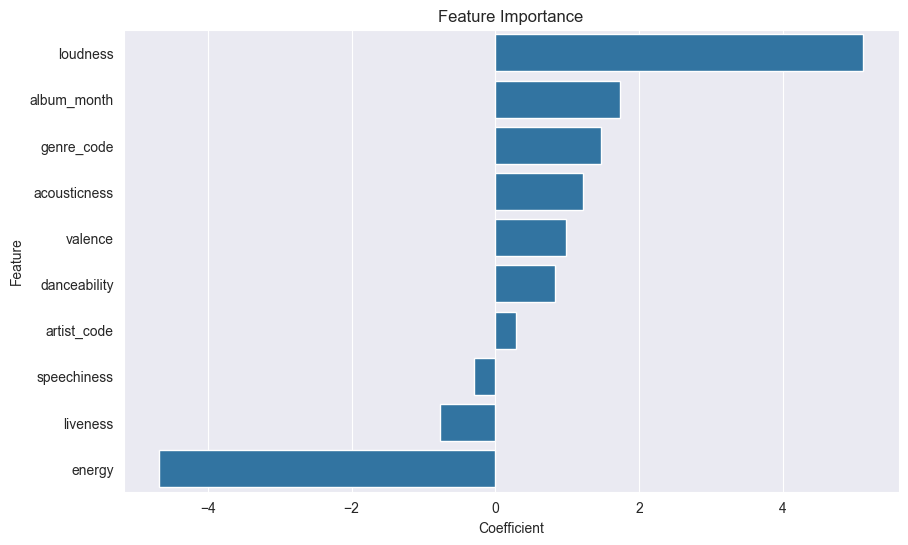

In [10]:
coefficients = model.coef_
features = X.columns

importance_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
importance_df = importance_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title('Feature Importance')
plt.show()

#### Actual vs Predicted

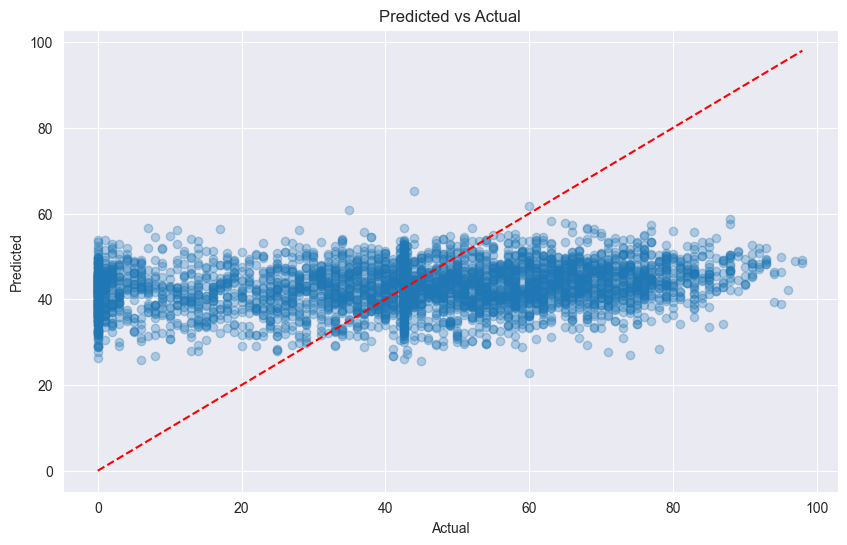

In [11]:
y_pred = model.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

#### Residuals

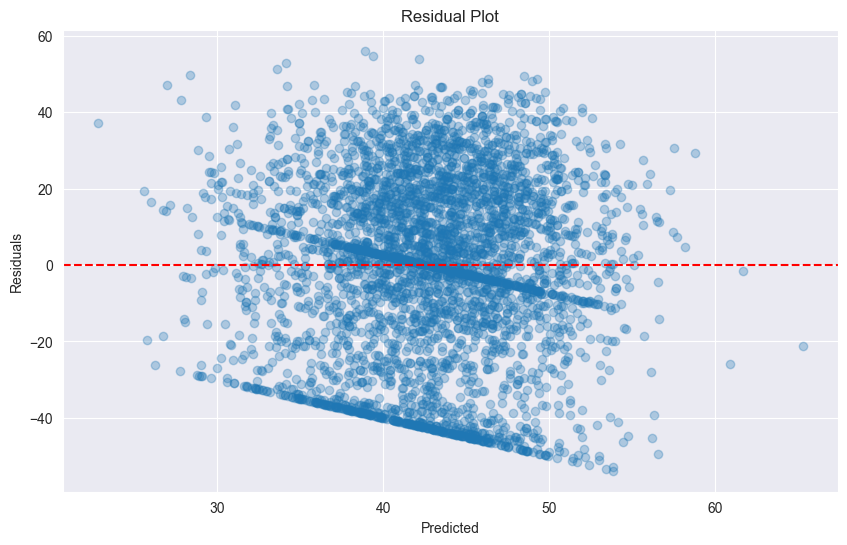

In [12]:
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()